In [1]:
## Import required libraries
########################################################################################
import xarray as xr              # for working with netcdf files
import pandas as pd              # we'll use dataframe objects from this library to do most data manipulation
import matplotlib.pyplot as plt  # for plotting
import os                        # for checking whether we need to create a new directory when saving plots

In [ ]:
## Define file directories and paths
########################################################################################
fDir_thisFile = '/home/local/WIN/cyasana1/Code/course_climInfDis/projectExample/' # directory in which this file lives
fDir_rawData = fDir_thisFile + 'rawData/'
filepath_T2M_dly     = fDir_rawData + 'MERRA2_tavg1_2d_slv_Nx.19800101_20211231.SUB.T2M.dly.nc' 
filepath_prcp_dly    = fDir_rawData + 'mergedDly_2001_2020.nc'

In [4]:
## Process data and store in dataframes
########################################################################################

# Subset data to locations of interest
Negombo_lat = 7.2008  # deg N
Negombo_lon = 79.8737 # deg E
Jaffna_lat  = 9.6615  # deg N
Jaffna_lon  = 80.0255 # deg E

ds_T2M_dly = xr.open_dataset(filepath_T2M_dly)
T2M_dly_Negombo = ds_T2M_dly['T2M'].sel(lat=Negombo_lat, lon=Negombo_lon, method="nearest")
T2M_dly_Negombo = T2M_dly_Negombo.drop_vars(['lat', 'lon'])
T2M_dly_Jaffna = ds_T2M_dly['T2M'].sel(lat=Jaffna_lat, lon=Jaffna_lon, method="nearest")
T2M_dly_Jaffna = T2M_dly_Jaffna.drop_vars(['lat', 'lon'])

ds_prcp_dly = xr.open_dataset(filepath_prcp_dly)
prcp_dly_Negombo = ds_prcp_dly['precipitationCal'].sel(lat=Negombo_lat, lon=Negombo_lon, method="nearest")
prcp_dly_Negombo = prcp_dly_Negombo.drop_vars(['lat', 'lon'])
prcp_dly_Jaffna = ds_prcp_dly['precipitationCal'].sel(lat=Jaffna_lat, lon=Jaffna_lon, method="nearest")
prcp_dly_Jaffna = prcp_dly_Jaffna.drop_vars(['lat', 'lon'])

# Subest data to a common time range
start_date = '2007-01-01' # earliest time across datasets (denInc)
end_date   = '2020-12-31' # latest time across datasets (IMERG prcp)

T2M_dly_Negombo = T2M_dly_Negombo.sel(time=slice(start_date, end_date))
T2M_dly_Jaffna = T2M_dly_Jaffna.sel(time=slice(start_date, end_date))
prcp_dly_Negombo = prcp_dly_Negombo.sel(time=slice(start_date, end_date))
prcp_dly_Jaffna = prcp_dly_Jaffna.sel(time=slice(start_date, end_date))

# Convert data from DataArrays to Pandas DataFrames
T2M_dly_Negombo = T2M_dly_Negombo.to_dataframe()
T2M_dly_Jaffna = T2M_dly_Jaffna.to_dataframe()
prcp_dly_Negombo = prcp_dly_Negombo.to_dataframe()
prcp_dly_Jaffna = prcp_dly_Jaffna.to_dataframe()

# Combine data into one dataframe per variable, where each column is a different location
T2M_dly = pd.concat([T2M_dly_Negombo, T2M_dly_Jaffna], axis=1)
T2M_dly.columns = ['Negombo', 'Jaffna']
prcp_dly = pd.concat([prcp_dly_Negombo, prcp_dly_Jaffna], axis=1)
prcp_dly.columns = ['Negombo', 'Jaffna']

# Convert units: the T2M data is in K but we want degrees C.
T2M_dly = T2M_dly - 273.15

print(T2M_dly)

                       Negombo     Jaffna
time                                     
2007-01-01 12:00:00  24.277069  25.544312
2007-01-02 12:00:00  24.033600  25.448303
2007-01-03 12:00:00  23.656097  24.973480
2007-01-04 12:00:00  22.778503  25.000824
2007-01-05 12:00:00  23.217102  25.149078
...                        ...        ...
2020-12-27 12:00:00  25.642822  26.117767
2020-12-28 12:00:00  25.819794  26.069458
2020-12-29 12:00:00  26.138519  26.239777
2020-12-30 12:00:00  26.629211  26.745758
2020-12-31 12:00:00  26.319092  26.456482

[5114 rows x 2 columns]


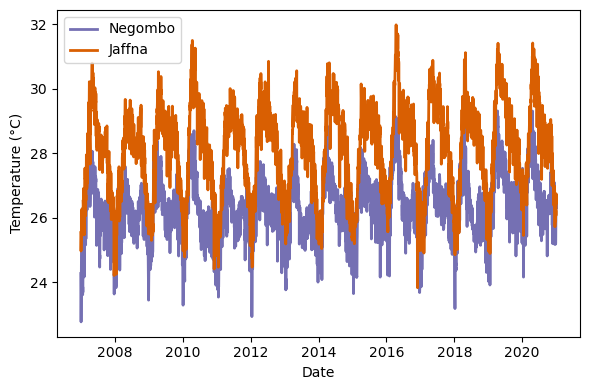

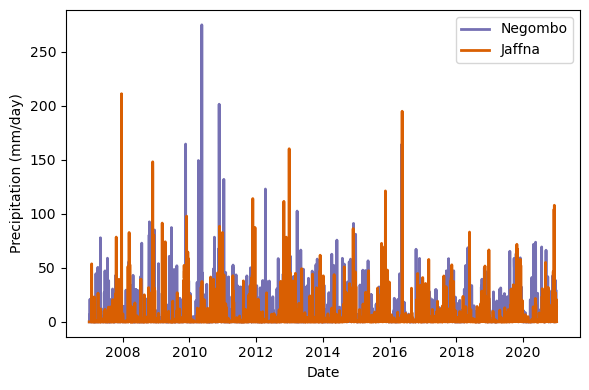

In [8]:
## Plot full daily timeseries for each location
########################################################################################

# Set colors for plotting
# Colors are from colorbrewer2.org (qualitative data; colorblind safe)
color_Negombo = '#7570b3'
color_Jaffna = '#d95f02'

# First, the temperature plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(T2M_dly.index, T2M_dly['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(T2M_dly.index, T2M_dly['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()


# Next, the precipitation plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(prcp_dly.index, prcp_dly['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(prcp_dly.index, prcp_dly['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (mm/day)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()

In [9]:
## Calculate daily climatologies
########################################################################################

# The full data record doesn't clearly show the seasonality of the two locations as well as we'd like
# (while it's decently obvious in temp, it's not obvious in prcp).
# So, let's calculate the climatologies for the two locations and plot those.

# Calculate climatologies
T2M_dly['DOY']  = T2M_dly.index.day_of_year # create day of year column
T2M_dlyClim_Negombo = T2M_dly.groupby('DOY')['Negombo'].mean() # calculate climatology
T2M_dlyClim_Jaffna  = T2M_dly.groupby('DOY')['Jaffna'].mean()   # calculate climatology
T2M_dlyClim = pd.DataFrame({'Negombo': T2M_dlyClim_Negombo, 'Jaffna': T2M_dlyClim_Jaffna}) # combine data into one df

prcp_dly['DOY'] = prcp_dly.index.day_of_year # create day of year column
prcp_dlyClim_Negombo = prcp_dly.groupby('DOY')['Negombo'].mean() # calculate climatology
prcp_dlyClim_Jaffna  = prcp_dly.groupby('DOY')['Jaffna'].mean()   # calculate climatology
prcp_dlyClim = pd.DataFrame({'Negombo': prcp_dlyClim_Negombo, 'Jaffna': prcp_dlyClim_Jaffna})  # combine data into one df

print(T2M_dlyClim)

       Negombo     Jaffna
DOY                      
1    25.190006  26.076262
2    25.259764  26.153944
3    25.221607  26.040457
4    25.038563  25.876755
5    25.014799  25.927166
..         ...        ...
362  25.125959  25.985189
363  25.212187  26.120388
364  25.407080  26.076773
365  25.504076  26.139746
366  25.600250  26.429199

[366 rows x 2 columns]


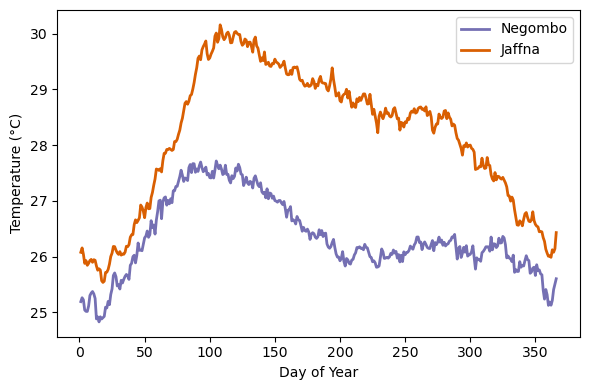

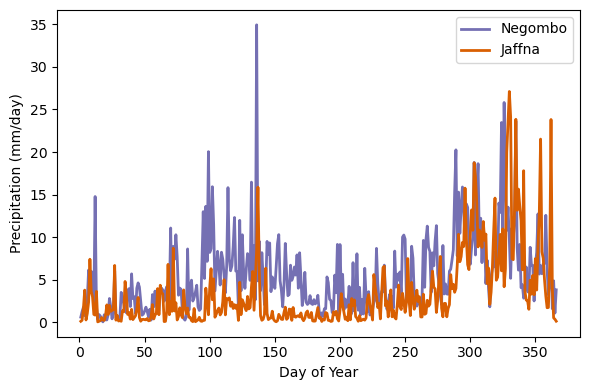

In [11]:
## Plot daily climatologies
########################################################################################

# First, the temperature plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(T2M_dlyClim.index, T2M_dlyClim['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(T2M_dlyClim.index, T2M_dlyClim['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Day of Year')
ax.set_ylabel('Temperature (°C)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()

# Next, the precipitation plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(prcp_dlyClim.index, prcp_dlyClim['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(prcp_dlyClim.index, prcp_dlyClim['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Day of Year')
ax.set_ylabel('Precipitation (mm/day)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

# Save the figure
plt.show()

In [12]:
## Calculate monthly values, monthly climatologies, and min/max values for each calendar month
########################################################################################

# Calculate monthly values from the daily data
T2M_monthly  = T2M_dly.resample('M').mean() # average over month
prcp_monthly = prcp_dly.resample('M').sum() # sum over month

# Calculate monthly climatology from the daily values
T2M_monthly['month']  = T2M_monthly.index.month # create month column
T2M_monthlyClim_Negombo = T2M_monthly.groupby('month')['Negombo'].mean() # calculate climatology
T2M_monthlyClim_Jaffna  = T2M_monthly.groupby('month')['Jaffna'].mean()   # calculate climatology
T2M_monthlyClim = pd.DataFrame({'Negombo': T2M_monthlyClim_Negombo, 'Jaffna': T2M_monthlyClim_Jaffna}) # combine data into one df

prcp_monthly['month']  = prcp_monthly.index.month # create month column
prcp_monthlyClim_Negombo = prcp_monthly.groupby('month')['Negombo'].mean() # calculate climatology
prcp_monthlyClim_Jaffna  = prcp_monthly.groupby('month')['Jaffna'].mean()   # calculate climatology
prcp_monthlyClim = pd.DataFrame({'Negombo': prcp_monthlyClim_Negombo, 'Jaffna': prcp_monthlyClim_Jaffna}) # combine data into one df

# Calculate min/max values for each calendar month
T2M_monthlyMin_Negombo = T2M_monthly.groupby('month')['Negombo'].min() # calculate min value
T2M_monthlyMin_Jaffna  = T2M_monthly.groupby('month')['Jaffna'].min()  # calculate min value
T2M_monthlyMin = pd.DataFrame({'Negombo': T2M_monthlyMin_Negombo, 'Jaffna': T2M_monthlyMin_Jaffna}) # combine data into one df
T2M_monthlyMax_Negombo = T2M_monthly.groupby('month')['Negombo'].max() # calculate max value
T2M_monthlyMax_Jaffna  = T2M_monthly.groupby('month')['Jaffna'].max()  # calculate max value
T2M_monthlyMax = pd.DataFrame({'Negombo': T2M_monthlyMax_Negombo, 'Jaffna': T2M_monthlyMax_Jaffna}) # combine data into one df

prcp_monthlyMin_Negombo = prcp_monthly.groupby('month')['Negombo'].min() # calculate min value
prcp_monthlyMin_Jaffna  = prcp_monthly.groupby('month')['Jaffna'].min()  # calculate min value
prcp_monthlyMin = pd.DataFrame({'Negombo': prcp_monthlyMin_Negombo, 'Jaffna': prcp_monthlyMin_Jaffna}) # combine data into one df
prcp_monthlyMax_Negombo = prcp_monthly.groupby('month')['Negombo'].max() # calculate max value
prcp_monthlyMax_Jaffna  = prcp_monthly.groupby('month')['Jaffna'].max()  # calculate max value
prcp_monthlyMax = pd.DataFrame({'Negombo': prcp_monthlyMax_Negombo, 'Jaffna': prcp_monthlyMax_Jaffna}) # combine data into one df

print(T2M_monthly)
print(T2M_monthlyClim)
print(T2M_monthlyMin)
print(T2M_monthlyMax)

              Negombo     Jaffna    DOY  month
time                                          
2007-01-31  24.832630  25.908707   16.0      1
2007-02-28  25.679125  26.669537   45.5      2
2007-03-31  27.273792  28.106546   75.0      3
2007-04-30  27.224245  29.351673  105.5      4
2007-05-31  27.305470  29.835796  136.0      5
...               ...        ...    ...    ...
2020-08-31  26.337788  28.734943  229.0      8
2020-09-30  26.184483  28.327604  259.5      9
2020-10-31  26.428633  28.427649  290.0     10
2020-11-30  26.638075  27.930696  320.5     11
2020-12-31  25.955154  26.471033  351.0     12

[168 rows x 4 columns]
         Negombo     Jaffna
month                      
1      25.203136  25.903366
2      26.089573  26.665247
3      27.259525  28.303839
4      27.522141  29.844687
5      27.272202  29.690393
6      26.654009  29.257030
7      26.128021  28.974115
8      26.032120  28.649353
9      26.154394  28.510721
10     26.163862  28.207163
11     26.105740  27.397404
1

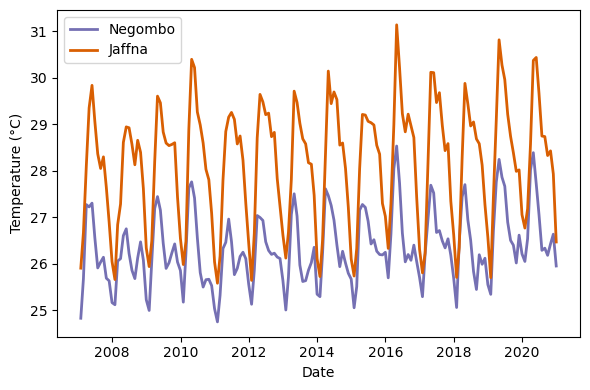

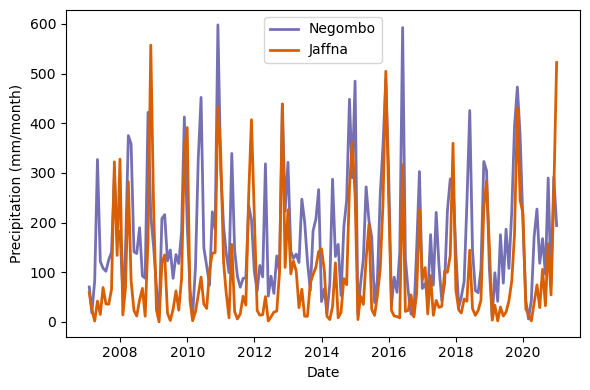

In [14]:
## Plot monthly values
########################################################################################

# First, the temperature plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(T2M_monthly.index, T2M_monthly['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(T2M_monthly.index, T2M_monthly['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()


# Next, the precipitation plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(prcp_monthly.index, prcp_monthly['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(prcp_monthly.index, prcp_monthly['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

# Add title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (mm/month)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()

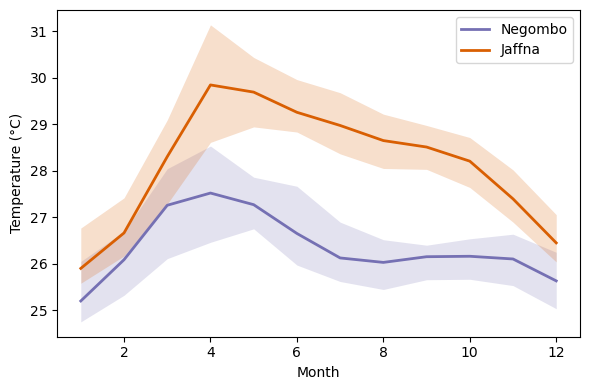

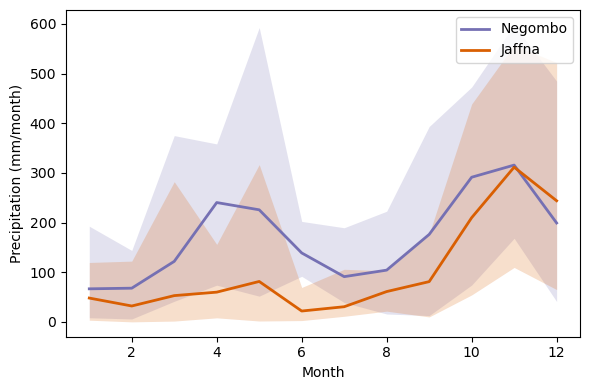

In [16]:
## Plot monthly climatologies with shading showing min/max for each calendar month
########################################################################################

# First, the temperature plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(T2M_monthlyClim.index, T2M_monthlyClim['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(T2M_monthlyClim.index, T2M_monthlyClim['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

ax.fill_between(T2M_monthlyClim.index, T2M_monthlyMin['Negombo'], T2M_monthlyMax['Negombo'], color=color_Negombo, linewidth=0, alpha=0.2)
ax.fill_between(T2M_monthlyClim.index, T2M_monthlyMin['Jaffna'], T2M_monthlyMax['Jaffna'], color=color_Jaffna, linewidth=0, alpha=0.2)

# Add title and labels
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()

# Next, the precipitation plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(prcp_monthlyClim.index, prcp_monthlyClim['Negombo'], label='Negombo', color=color_Negombo, linestyle='-', linewidth=2)
ax.plot(prcp_monthlyClim.index, prcp_monthlyClim['Jaffna'], label='Jaffna', color=color_Jaffna, linestyle='-', linewidth=2)

ax.fill_between(prcp_monthlyClim.index, prcp_monthlyMin['Negombo'], prcp_monthlyMax['Negombo'], color=color_Negombo, linewidth=0, alpha=0.2)
ax.fill_between(prcp_monthlyClim.index, prcp_monthlyMin['Jaffna'], prcp_monthlyMax['Jaffna'], color=color_Jaffna, linewidth=0, alpha=0.2)

# Add title and labels
ax.set_xlabel('Month')
ax.set_ylabel('Precipitation (mm/month)')

# Show legend
ax.legend()

# Adjust layout to avoid label cutoff
plt.tight_layout()

plt.show()